#Treinamento da Rede U-NeT para segmentação da região do pulmão

In [1]:
# Monta o drive para ler os dados salvos no mesmo
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip3 install pickle5
import pickle5 as pickle

In [3]:
import os
#import pickle
import cv2
import nibabel as nib
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

In [4]:
def normImage(image):
    image-=np.min(image)
    if np.max(image)!=0:
      image = (image/np.max(image))
    return image

In [5]:
def get_model(IMG_HEIGHT, IMG_WIDTH, CHANNELS):
    in1 = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS ))

    conv1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = layers.Dropout(0.2)(conv1)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = layers.Dropout(0.2)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = layers.Dropout(0.2)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = layers.Dropout(0.2)(conv4)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = layers.concatenate([layers.UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = layers.Dropout(0.2)(conv5)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = layers.concatenate([layers.UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = layers.Dropout(0.2)(conv6)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = layers.concatenate([layers.UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = layers.Dropout(0.2)(conv7)
    conv7 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = layers.Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    losses = {'seg': 'binary_crossentropy'
            }

    metrics = {'seg': ['acc']
                }
    model.compile(optimizer="adam", loss = losses, metrics=metrics)

    return model

In [6]:
ct0_path = "/content/gdrive/MyDrive/COVID19_1110/studies/CT-0"
ct1_path = "/content/gdrive/MyDrive/COVID19_1110/studies/CT-1"
ct2_path = "/content/gdrive/MyDrive/COVID19_1110/studies/CT-2"

#
masks_path = "/content/gdrive/MyDrive/COVID19_1110/masks"

mask_files = os.listdir(masks_path)
mask_files.sort()
#
ct0_files = os.listdir(ct0_path)
ct0_files.sort()
ct1_files = os.listdir(ct1_path)
ct1_files.sort()
ct2_files = os.listdir(ct2_path)
ct2_files.sort()

In [7]:
train_data = []
test_data = []
train_labels = []
test_labels = []

for f_idx,f in enumerate(mask_files): 
    print(f)
    full_mask_path = os.path.join(masks_path, f)
    
    mask = nib.load(full_mask_path)
    n_masks = mask.dataobj.shape[-1]
    
    image_name_parts = f.split('_mask')
    image_name = image_name_parts[0]+image_name_parts[-1]
    if image_name in ct1_files:
        full_image_path = os.path.join(ct1_path, image_name) 
        ct_image = nib.load(full_image_path)
    elif image_name in ct2_files:
        full_image_path = os.path.join(ct2_path, image_name)
        ct_image = nib.load(full_image_path)
    else:
        print("vish")
        print(image_name)
        break
    
    
    id_m = [] # armazena os indices do arquivo que contém marcações
    
    ht_image_path = os.path.join(ct0_path, ct0_files[f_idx]) 
    cth_image = nib.load(ht_image_path)
      
    for m_slice in range(n_masks):
        norm_cvd_img = normImage(cv2.resize(ct_image.dataobj[:,:,m_slice],
                                           (128,128),
                                           cv2.INTER_LINEAR))    
        
        norm_mask_img = normImage(cv2.resize(mask.dataobj[:,:,m_slice],
                                           (128,128),
                                           cv2.INTER_LINEAR))
        norm_mask_img[norm_mask_img>0] = 1
        norm_mask_img[norm_mask_img<=0] = 0

        
        if f_idx<40:
            train_data.append(norm_cvd_img.copy())
            train_labels.append( norm_mask_img.copy())
        else:
            test_data.append(norm_cvd_img.copy())
            test_labels.append(norm_mask_img.copy())

study_0255_mask.nii.gz
study_0256_mask.nii.gz
study_0257_mask.nii.gz
study_0258_mask.nii.gz
study_0259_mask.nii.gz
study_0260_mask.nii.gz
study_0261_mask.nii.gz
study_0262_mask.nii.gz
study_0263_mask.nii.gz
study_0264_mask.nii.gz
study_0265_mask.nii.gz
study_0266_mask.nii.gz
study_0267_mask.nii.gz
study_0268_mask.nii.gz
study_0269_mask.nii.gz
study_0270_mask.nii.gz
study_0271_mask.nii.gz
study_0272_mask.nii.gz
study_0273_mask.nii.gz
study_0274_mask.nii.gz
study_0275_mask.nii.gz
study_0276_mask.nii.gz
study_0277_mask.nii.gz
study_0278_mask.nii.gz
study_0279_mask.nii.gz
study_0280_mask.nii.gz
study_0281_mask.nii.gz
study_0282_mask.nii.gz
study_0283_mask.nii.gz
study_0284_mask.nii.gz
study_0285_mask.nii.gz
study_0286_mask.nii.gz
study_0287_mask.nii.gz
study_0288_mask.nii.gz
study_0289_mask.nii.gz
study_0290_mask.nii.gz
study_0291_mask.nii.gz
study_0292_mask.nii.gz
study_0293_mask.nii.gz
study_0294_mask.nii.gz
study_0295_mask.nii.gz
study_0296_mask.nii.gz
study_0297_mask.nii.gz
study_0298_

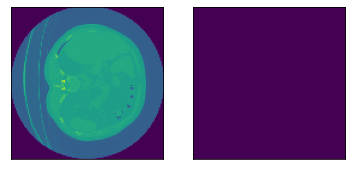

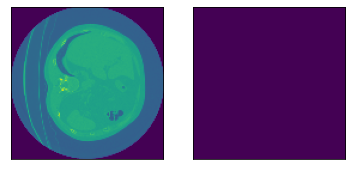

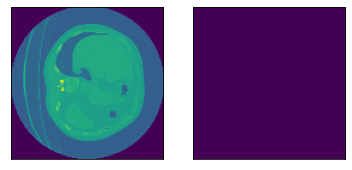

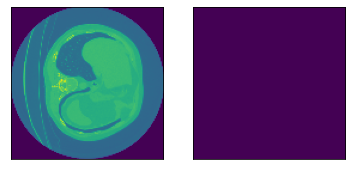

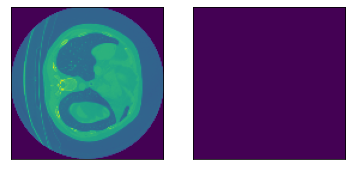

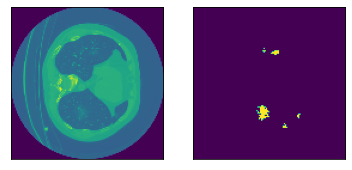

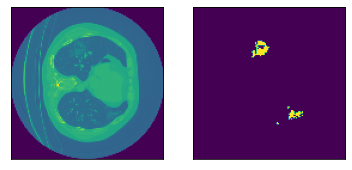

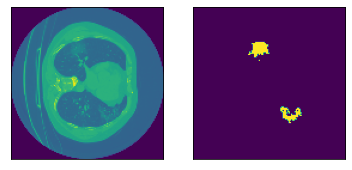

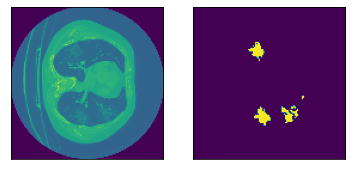

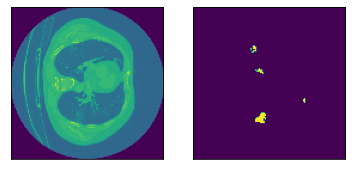

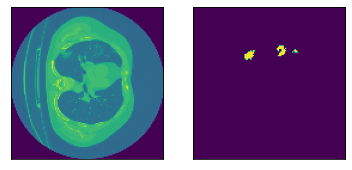

In [37]:
#apresentar parte do dataset
for i in range(1,23,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(train_data[i].reshape((128,128)))
    ax2.imshow(train_labels[i].reshape((128,128)))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])

In [9]:
#Remodelar os dados  
train_data=np.array(train_data)
train_data = train_data.reshape((train_data.shape[0],train_data.shape[1],train_data.shape[2],1))
train_labels=np.array(train_labels)
train_labels = train_labels.reshape((train_labels.shape[0],train_labels.shape[1],train_labels.shape[2],1))

test_data=np.array(test_data)
test_data = test_data.reshape((test_data.shape[0],test_data.shape[1],test_data.shape[2],1))
test_labels=np.array(test_labels)
test_labels = test_labels.reshape((test_labels.shape[0],test_labels.shape[1],test_labels.shape[2],1))

In [10]:
#criar modelo
model = get_model(IMG_HEIGHT=train_data.shape[1], 
                  IMG_WIDTH=train_data.shape[2], 
                  CHANNELS=train_data.shape[3])

In [11]:
#Treinar o modelo por 500 épocas
EPOCHS=100
BATCH_SIZE=128

history = model.fit(train_data, train_labels , epochs=EPOCHS, 
                      batch_size = BATCH_SIZE,shuffle=True, 
                      validation_data=(test_data, test_labels))

Epoch 1/100
13/13 [==============================] - 26s 1s/step - loss: 0.0955 - acc: 0.9812 - val_loss: 0.0962 - val_acc: 0.9980
Epoch 2/100
13/13 [==============================] - 7s 529ms/step - loss: 0.0171 - acc: 0.9983 - val_loss: 0.0416 - val_acc: 0.9980
Epoch 3/100
13/13 [==============================] - 7s 534ms/step - loss: 0.0127 - acc: 0.9983 - val_loss: 0.0197 - val_acc: 0.9980
Epoch 4/100
13/13 [==============================] - 7s 536ms/step - loss: 0.0118 - acc: 0.9983 - val_loss: 0.0230 - val_acc: 0.9980
Epoch 5/100
13/13 [==============================] - 7s 538ms/step - loss: 0.0111 - acc: 0.9983 - val_loss: 0.0216 - val_acc: 0.9980
Epoch 6/100
13/13 [==============================] - 7s 542ms/step - loss: 0.0107 - acc: 0.9983 - val_loss: 0.0155 - val_acc: 0.9980
Epoch 7/100
13/13 [==============================] - 7s 545ms/step - loss: 0.0109 - acc: 0.9983 - val_loss: 0.0170 - val_acc: 0.9980
Epoch 8/100
13/13 [==============================] - 7s 550ms/step - lo

Text(0.5, 1.0, 'Acurácia')

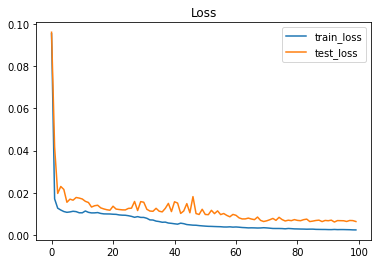

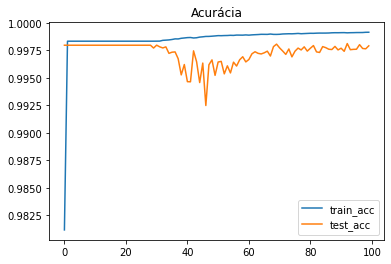

In [12]:
plt.figure()
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='test_loss')
plt.legend()
plt.title('Loss')
plt.figure()
plt.plot(history.history['acc'],label='train_acc')
plt.plot(history.history['val_acc'],label='test_acc')
plt.legend()
plt.title('Acurácia')

In [14]:
model.save(os.path.join('/content/gdrive/MyDrive/dados','DNN_covid_masks.hdf5')) #Salvar o modelo

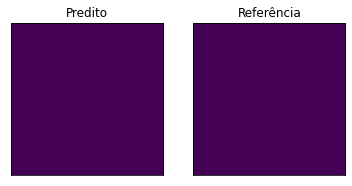

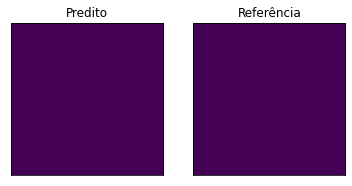

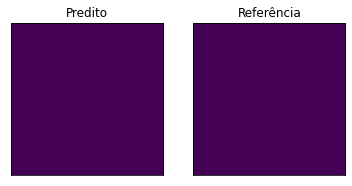

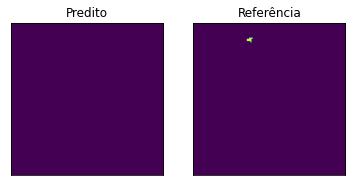

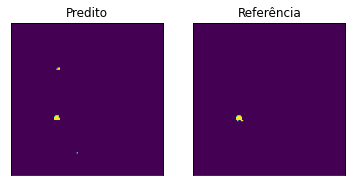

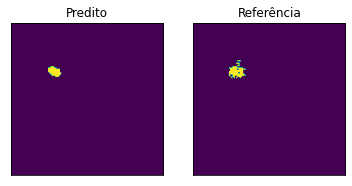

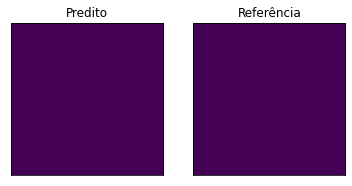

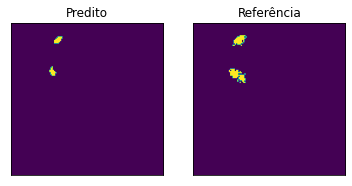

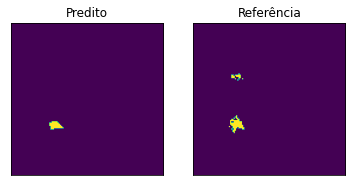

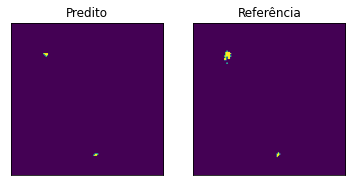

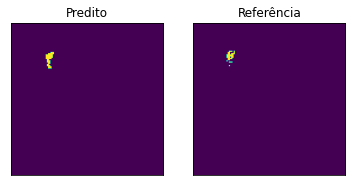

In [33]:
#verificar algumas das amostras
for i in range(1,23,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.round(model.predict(test_data[i].reshape(1,128,128,1))).reshape(128,128))
    ax2.imshow(test_labels[i].reshape(128,128))
    ax1.set_title("Predito")
    ax2.set_title("Referência")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])

In [25]:
#verificar a quantidade de frames que possuem mascaras
is_infected_true = []
is_infected_pred = []
for label,frame in zip(test_labels,test_data):
  pred_mask = model.predict(frame.reshape(1,128,128,1))
  if np.max(label) > 0:
    is_infected_true.append(1)
  else:
    is_infected_true.append(0)

  pred_mask = np.round(pred_mask)
  if np.max(pred_mask) > 0:
    is_infected_pred.append(1)
  else:
    is_infected_pred.append(0)

is_infected_true = np.array(is_infected_true)
is_infected_pred = np.array(is_infected_pred)

In [39]:
from sklearn import metrics

acc = metrics.accuracy_score(is_infected_true,is_infected_pred)
print(acc)

cm = metrics.confusion_matrix(is_infected_true,is_infected_pred,labels = [0,1])
print(cm)
tn, fp, fn, tp = cm.ravel()


0.823960880195599
[[216  35]
 [ 37 121]]
216 35 37 121
